# **Setup**

1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [1]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [2]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [4]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

# Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting the right PATH

In [8]:
%pwd

'c:\\Users\\ttt\\Documents\\GitHub\\BilderkennungAI'

In [7]:
%cd "/content/drive/MyDrive/Programming/BilderkennungAI"

[WinError 3] Das System kann den angegebenen Pfad nicht finden: '/content/drive/MyDrive/Programming/BilderkennungAI'
c:\Users\ttt\Documents\GitHub\BilderkennungAI


# Bilder labeln



```
!labelme
```

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Trennung der data/images Ordner in 3 kleineren Ordnern
```
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)


#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)

#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)
```



Die passende Label für jedes Bildes in der richtige Ordner anordnen


```
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)
```



Image in eine tf data pipeline laden (Beispiel)

In [9]:
images = tf.data.Dataset.list_files(os.path.join('data/train/images/*.jpg'))

In [10]:
images.as_numpy_iterator().next()

b'data\\train\\images\\image84.jpg'

In [11]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(120,120))
    img = img/255
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[0.24460104, 0.2893723 , 0.25718272],
        [0.25520834, 0.29524103, 0.26386848],
        [0.24869281, 0.29941452, 0.26424974],
        ...,
        [0.17758049, 0.21679617, 0.18542363],
        [0.2036152 , 0.23351716, 0.19479166],
        [0.19655511, 0.22400609, 0.19263354]],

       [[0.2549224 , 0.3166871 , 0.28776553],
        [0.28265932, 0.3375    , 0.30422795],
        [0.27316177, 0.32855392, 0.2917892 ],
        ...,
        [0.19091082, 0.22277357, 0.19385199],
        [0.2009804 , 0.22843137, 0.19705883],
        [0.20018376, 0.22763474, 0.20018376]],

       [[0.27892157, 0.34607843, 0.31454247],
        [0.31556374, 0.36697304, 0.334518  ],
        [0.29836598, 0.3498366 , 0.31045747],
        ...,
        [0.19968668, 0.22713766, 0.19968668],
        [0.18807189, 0.21552287, 0.18807189],
        [0.20212388, 0.22957486, 0.20212388]],

       ...,

       [[0.6143913 , 0.5722004 , 0.46341103],
        [0.6239972 , 0.5918487 , 0.4826371 ],
        [0.6009031 , 0

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Image visualisieren 

In [15]:
images_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = images_generator.next()

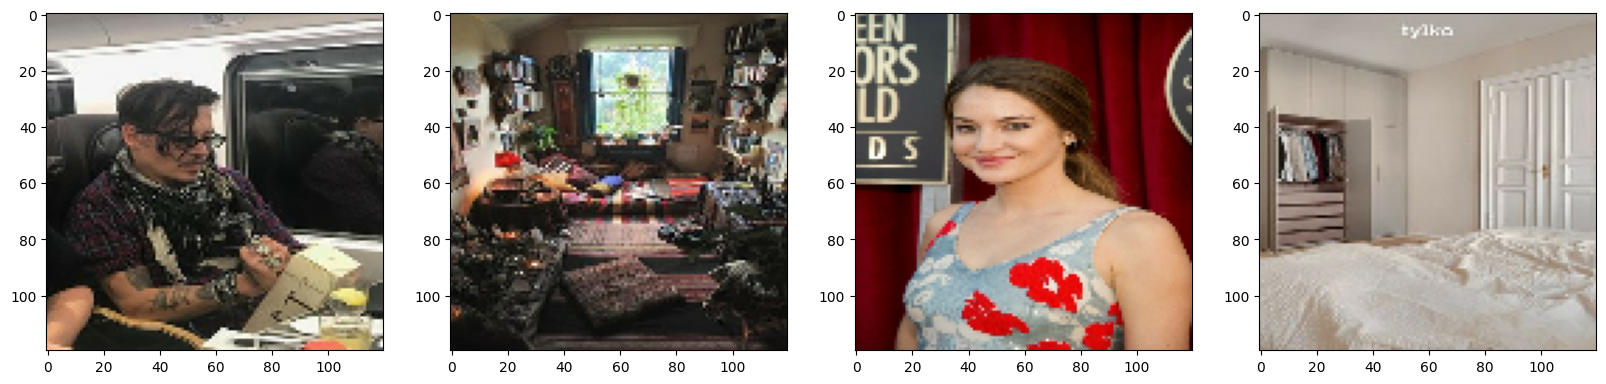

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [31]:
augmentor = alb.Compose([alb.RandomCrop(width=500,height=500),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))
#

Laden eines Beispielbilds

In [155]:
image_path = "image21"

In [156]:
img = cv2.imread(os.path.join('data','train','images',image_path+".jpg"))

In [157]:
size= img.shape
print(size)

(650, 650, 3)


Koordinaten Extrahieren und Maßstab ändern

In [158]:
coords = [0,0,0.0001,0.0001]
label_path = os.path.join('data', 'train', 'labels', f'{image_path}.json')
if os.path.exists(label_path):
  with open(label_path, 'r') as f:
   label = json.load(f)
  coords[0] = label['shapes'][0]['points'][0][0]
  coords[1] = label['shapes'][0]['points'][0][1]
  coords[2] = label['shapes'][0]['points'][1][0]
  coords[3] = label['shapes'][0]['points'][1][1]
  coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))


In [ ]:
label['shapes'][0]['points']

In [159]:
coords

[0.2928381962864722,
 0.17458885941644564,
 0.6122015915119363,
 0.483342175066313]

Augmentation implimentieren

In [160]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [145]:
augmented['bboxes']


[(0.21282758620689668, 0.5543448275862068, 0.5990344827586207, 1.0)]

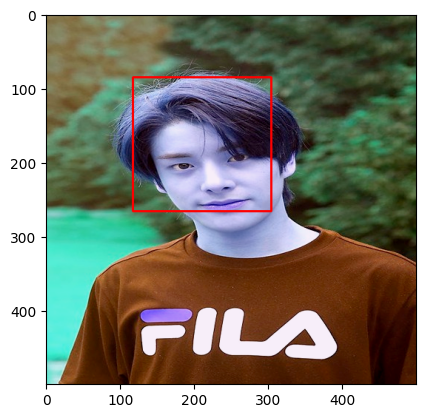

In [161]:
if(augmented['bboxes']):
 cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

Aug-data Ordner herstellen

In [147]:
for path in ['train','test','val']:
  for folder in ['images','labels']:
   PATH = os.path.join('aug_data',path,folder)
   os.makedirs(PATH)

# **5. Augmentation Pipeline durchführen**

In [148]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        size = img.shape

        coords = [0,0,0.000001,0.000001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
            print(label_path)

x_max is less than or equal to x_min for bbox [0.6238726790450928, 0.5544297082228117, 0.19628647214854114, 0.08015915119363395, 'face'].
data\train\labels\image22.json
x_max is less than or equal to x_min for bbox [0.5920424403183026, 0.5544297082228117, 0.10079575596816977, 0.05893899204244032, 'face'].
data\train\labels\image23.json
x_max is less than or equal to x_min for bbox [0.6153846153846154, 0.3931564986737401, 0.38196286472148544, 0.13320954907161806, 'face'].
data\train\labels\image25.json
x_max is less than or equal to x_min for bbox [0.6206896551724138, 0.08228116710875331, 0.35862068965517246, 0.42180371352785145, 'face'].
data\train\labels\image31.json
x_max is less than or equal to x_min for bbox [0.6992042440318302, 0.48864721485411144, 0.26631299734748015, 0.07379310344827586, 'face'].
data\train\labels\image36.json
x_max is less than or equal to x_min for bbox [0.5941644562334218, 0.2520424403183024, 0.3618037135278515, 0.045145888594164456, 'face'].
data\train\labe

## **6.Die Augmented Bildern zu eine Tensorflow Dataset laden**

In [45]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle= False)
train_images = train_images.map(load_image)

In [46]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle= False)
test_images = test_images.map(load_image)

In [47]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle= False)
val_images = val_images.map(load_image)

In [48]:
train_images.as_numpy_iterator().next()

array([[[0.37938455, 0.42126906, 0.3846405 ],
        [0.36609477, 0.41609475, 0.37687907],
        [0.3563998 , 0.41116557, 0.3605937 ],
        ...,
        [0.27450982, 0.3019608 , 0.27058825],
        [0.29109493, 0.31977126, 0.28897053],
        [0.27747822, 0.3166939 , 0.2813998 ]],

       [[0.41209152, 0.4620915 , 0.42287582],
        [0.40808824, 0.45882353, 0.41960785],
        [0.41633984, 0.4640523 , 0.41666666],
        ...,
        [0.2870913 , 0.32557186, 0.29052278],
        [0.29117623, 0.3186272 , 0.28749973],
        [0.2957516 , 0.32320258, 0.29183003]],

       [[0.42802286, 0.49169388, 0.45234203],
        [0.4357843 , 0.4894608 , 0.44934642],
        [0.43494007, 0.48562092, 0.44640523],
        ...,
        [0.28140002, 0.3206157 , 0.2853216 ],
        [0.29436263, 0.3218136 , 0.29052272],
        [0.28491288, 0.31236386, 0.28491288]],

       ...,

       [[0.8459424 , 0.8956156 , 0.9050927 ],
        [0.98227125, 1.        , 1.        ],
        [0.9767973 , 1

Labels vorbereiten

In [49]:
def load_labels(label_path):
  with open(label_path.numpy(),'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']],label['bbox']

In [50]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [51]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [52]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [53]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.09485, 0.026  , 0.481  , 0.5957 ], dtype=float16))

# **7. Combine Image and Label Sampels**

7.1 Check Partition Lengths

In [54]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images), len(val_labels)

(2280, 2280, 900, 900, 540, 540)

7.2 Create Final Dataset (Image/Label)

In [55]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [56]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [57]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [59]:
train.as_numpy_iterator().next()

(array([[[[0.76004905, 0.5590686 , 0.42938453],
          [0.6882353 , 0.5017974 , 0.3636438 ],
          [0.41693905, 0.2902778 , 0.19583338],
          ...,
          [0.21889995, 0.16830073, 0.14477132],
          [0.1911766 , 0.14803934, 0.12450992],
          [0.18692806, 0.13888885, 0.12483656]],
 
         [[0.575     , 0.4267974 , 0.3162582 ],
          [0.5026961 , 0.35661766, 0.2637255 ],
          [0.39509806, 0.2866013 , 0.21307191],
          ...,
          [0.2085785 , 0.1636438 , 0.1401144 ],
          [0.19705907, 0.15392181, 0.1303924 ],
          [0.19215687, 0.15490197, 0.13627452]],
 
         [[0.43959695, 0.31830063, 0.22535402],
          [0.3771242 , 0.26143792, 0.1888889 ],
          [0.32652506, 0.23624729, 0.18131809],
          ...,
          [0.21535955, 0.1722223 , 0.14869289],
          [0.21339892, 0.17026167, 0.14673226],
          [0.19033228, 0.1628813 , 0.13935189]],
 
         ...,
 
         [[0.600272  , 0.5028048 , 0.44313687],
          [0.55122

7.3 View Images and Annotations

In [60]:
data_samples = train.as_numpy_iterator()

In [61]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


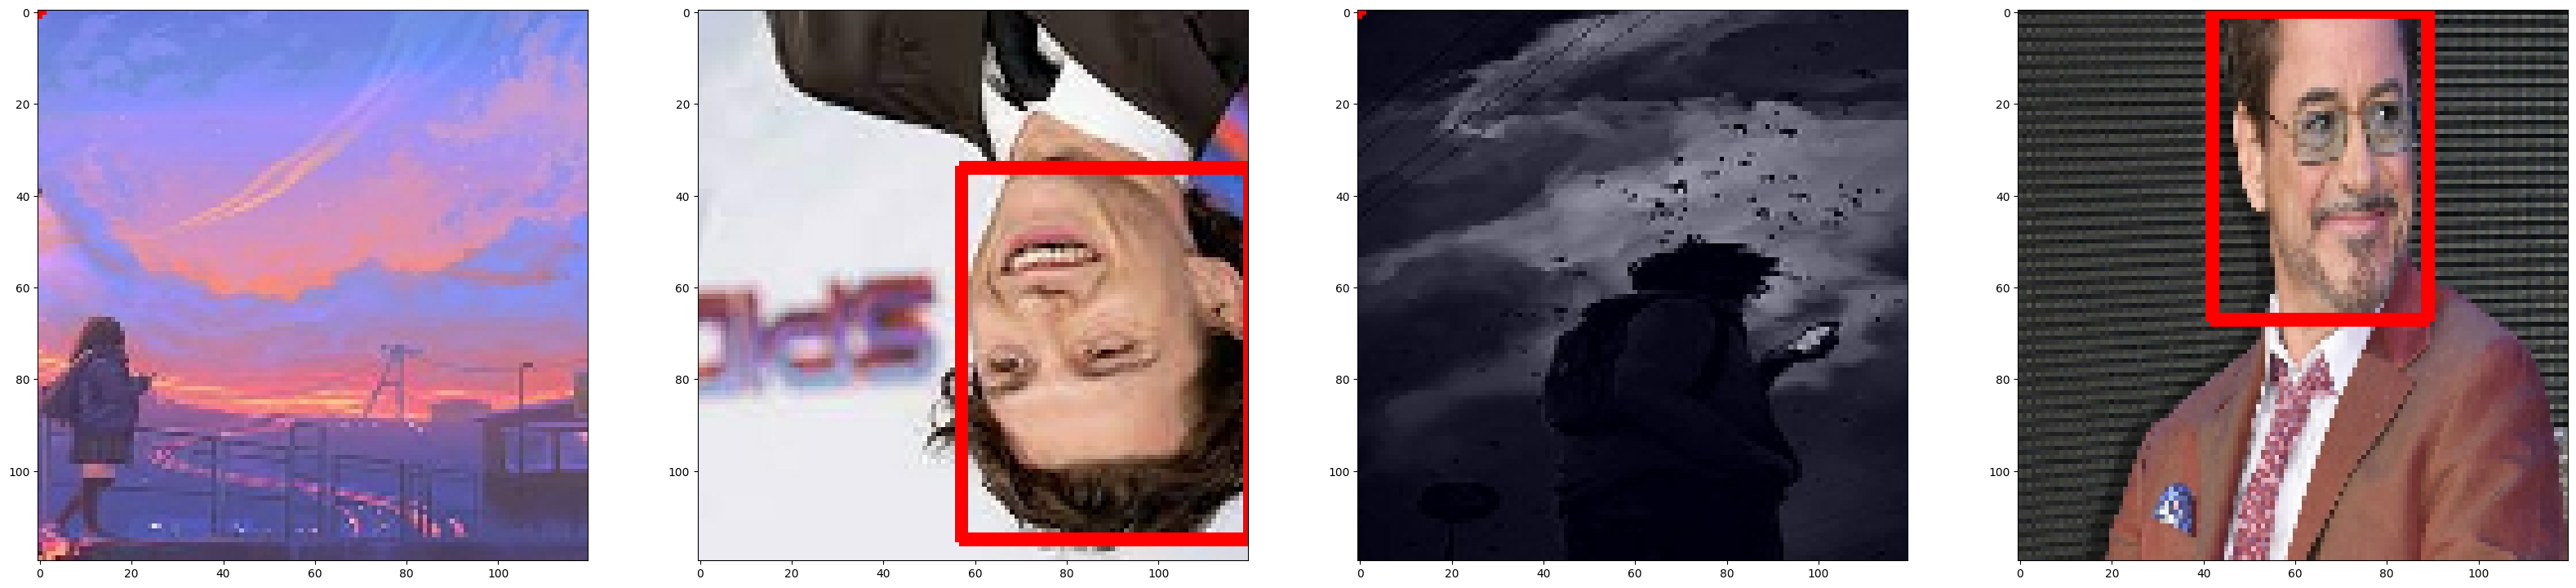

In [62]:
fig, ax = plt.subplots(ncols=4, figsize=(40, 40))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# **8. Aufbauen des Deep Learning-Modells**

### 8.1 Base Network sowie Layers importieren und VGG16 installieren

In [63]:
vgg = VGG16(include_top=False)

In [64]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Eine Instanz des Neural Networks bauen

In [65]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.3 Testen des Neural Networks

In [66]:
facetracker = build_model()

In [67]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [68]:
X, y = train.as_numpy_iterator().next()

In [81]:
y[1][:,:2]

array([[0.2986, 0.5024],
       [0.    , 0.    ],
       [0.    , 0.    ],
       [0.3555, 0.231 ],
       [0.    , 0.    ],
       [0.2361, 0.    ],
       [0.    , 0.    ],
       [0.    , 0.    ]], dtype=float16)

In [69]:
X.shape

(8, 120, 120, 3)

In [70]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 13s 13s/step


In [84]:
classes, coords

(array([[0.63488114],
        [0.59918165],
        [0.59108144],
        [0.5700356 ],
        [0.48037758],
        [0.515878  ],
        [0.5363868 ],
        [0.66597885]], dtype=float32),
 array([[0.33169374, 0.6225426 , 0.5547378 , 0.4905357 ],
        [0.3799967 , 0.55570126, 0.47422254, 0.5872036 ],
        [0.36081144, 0.48275596, 0.5456604 , 0.5861052 ],
        [0.3154798 , 0.5453896 , 0.57462376, 0.47293827],
        [0.32946682, 0.5989472 , 0.50677794, 0.46866298],
        [0.36095604, 0.5706085 , 0.5517855 , 0.5929327 ],
        [0.3858966 , 0.5392303 , 0.5078081 , 0.42040613],
        [0.29791206, 0.50400317, 0.51296437, 0.51336575]], dtype=float32))

In [83]:
coords[:,:2]

array([[0.33169374, 0.6225426 ],
       [0.3799967 , 0.55570126],
       [0.36081144, 0.48275596],
       [0.3154798 , 0.5453896 ],
       [0.32946682, 0.5989472 ],
       [0.36095604, 0.5706085 ],
       [0.3858966 , 0.5392303 ],
       [0.29791206, 0.50400317]], dtype=float32)

# **9.Define Losses and Optimizer**

## 9.1 Define Optimizer

In [72]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/ batches_per_epoch

In [73]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [90]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [91]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [92]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.2199407>

In [93]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7508315>

In [94]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.2199407>

# **10.Train Neural Network**

## 10.1 Create Custom Model Class

In [95]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [96]:
model = FaceTracker(facetracker)

In [97]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [98]:
logdir='logs'

In [99]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [100]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
285/285 [==============================] - 105s 295ms/step - total_loss: 0.3789 - class_loss: 0.0726 - regress_loss: 0.3426 - val_total_loss: 0.2446 - val_class_loss: 0.1846 - val_regress_loss: 0.1523
Epoch 2/15
285/285 [==============================] - 80s 262ms/step - total_loss: 0.0479 - class_loss: 0.0081 - regress_loss: 0.0439 - val_total_loss: 0.0518 - val_class_loss: 2.1071e-05 - val_regress_loss: 0.0518
Epoch 3/15
285/285 [==============================] - 54s 171ms/step - total_loss: 0.0304 - class_loss: 0.0025 - regress_loss: 0.0292 - val_total_loss: 0.0259 - val_class_loss: 1.6479e-04 - val_regress_loss: 0.0258
Epoch 4/15
285/285 [==============================] - 57s 182ms/step - total_loss: 0.0143 - class_loss: 0.0037 - regress_loss: 0.0125 - val_total_loss: 0.0083 - val_class_loss: 8.3519e-05 - val_regress_loss: 0.0083
Epoch 5/15
285/285 [==============================] - 99s 330ms/step - total_loss: 0.0069 - class_loss: 1.4646e-04 - regress_loss: 0.0069 - val

## 10.3 Plot Performance

In [ ]:
hist.history

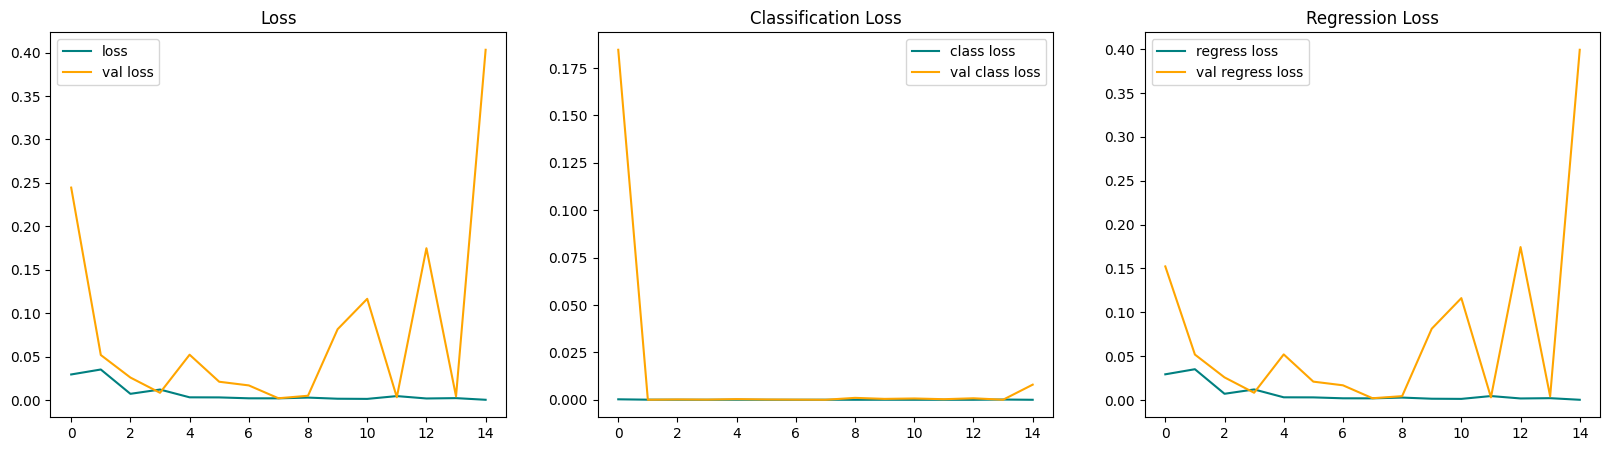

In [101]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# **11. Make Prediction**

## 11.1 Making Prediction on test set for valuation purpose

In [102]:
test_data = test.as_numpy_iterator()

In [103]:
test_sample = test_data.next()
test_sample

(array([[[[0.9848856 , 0.991122  , 0.9617103 ],
          [0.9941176 , 0.9898693 , 0.98308825],
          [0.9916122 , 0.9909586 , 0.9912854 ],
          ...,
          [0.8677837 , 0.88347   , 0.78477734],
          [0.55956095, 0.58693016, 0.43562347],
          [0.17410164, 0.2460244 , 0.00762541]],
 
         [[0.99174833, 0.9946895 , 0.9799836 ],
          [0.9892157 , 0.9872549 , 0.9823529 ],
          [0.9962418 , 0.9883987 , 0.9924836 ],
          ...,
          [0.560213  , 0.59085023, 0.40482125],
          [0.6784286 , 0.7198502 , 0.46764454],
          [0.99526143, 1.        , 0.79820263]],
 
         [[0.9880446 , 0.9953704 , 0.9831427 ],
          [0.9512255 , 0.9584151 , 0.95416665],
          [0.9879902 , 0.9951797 , 0.99158496],
          ...,
          [0.30531037, 0.34517956, 0.09547952],
          [0.44419932, 0.49158496, 0.19942808],
          [0.46029338, 0.50702536, 0.22271167]],
 
         ...,
 
         [[0.7620097 , 0.7620097 , 0.80422103],
          [0.81421

In [104]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 37ms/step


In [105]:
yhat

[array([[1.4088887e-07],
        [9.6436663e-05],
        [5.5205089e-07],
        [9.9993443e-01],
        [9.9999952e-01],
        [5.3879085e-05],
        [9.9992108e-01],
        [9.9999857e-01]], dtype=float32),
 array([[1.98299691e-04, 1.02086247e-04, 3.31248943e-04, 1.96904308e-04],
        [4.08858620e-03, 6.84124697e-03, 1.04544545e-02, 1.01847695e-02],
        [5.03971940e-04, 3.92233778e-04, 6.85314299e-04, 4.60068550e-04],
        [1.08689651e-01, 6.03296816e-01, 6.23059034e-01, 9.72887874e-01],
        [1.95022747e-01, 4.50102612e-03, 8.79183769e-01, 5.70196152e-01],
        [2.96280347e-03, 2.81309290e-03, 7.34603172e-03, 6.11688523e-03],
        [2.21060425e-01, 5.52196085e-01, 7.43821084e-01, 9.63458419e-01],
        [2.51359999e-01, 3.36794718e-03, 8.87937248e-01, 3.69920671e-01]],
       dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


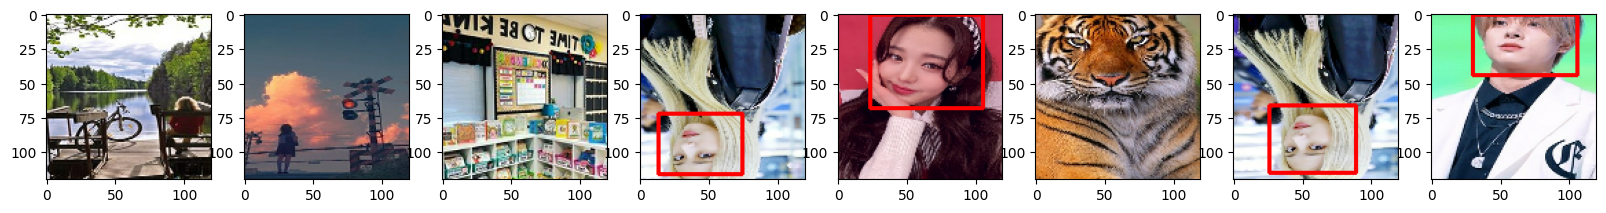

In [106]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx in range(8): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [107]:
#Model Speicherung
from tensorflow.keras.models import load_model

In [108]:
facetracker.save('facetracker.h5')

In [109]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [129]:
rtp_test = cv2.imread(os.path.join("producttest/Christian_Lindner.jpg"))

In [130]:
resized = tf.image.resize(rtp_test, (120,120))
size = rtp_test.shape
yhat = facetracker.predict(np.expand_dims(resized/255,0))
status = yhat[0]
sample_coords = yhat[1][0]


1/1 [==============================] - 0s 40ms/step


Es gibt ein Gesicht


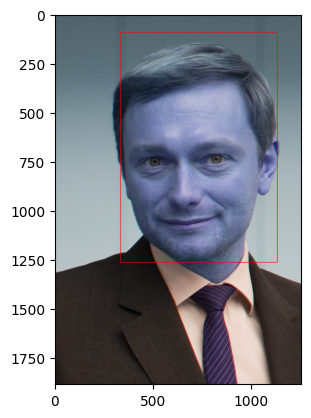

In [131]:
if (status > 0.5):
    print("Es gibt ein Gesicht")
    cv2.rectangle(rtp_test,
              tuple(np.multiply(sample_coords[:2], [size[1],size[0]]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [size[1],size[0]]).astype(int)),
              (255,0,0),2)
else:
    print("Es gibt kein Gesicht")
plt.imshow(rtp_test)